# Examples II - Inferring $v_{\rm rot}$ By Modelling the Line as a Gaussian Process

This Notebook builds upon the previous [Notebook](Examples%20-%20I.ipynb) and demonstrates the improves made in the technique as described in Teague et al. (2018b). To be able to play with this you need to have installed the [`celerite`](http://celerite.readthedocs.io/en/stable/) 1-D Gaussian Process package and [`emcee`](http://dfm.io/emcee/current/) for running the MCMC.

## Idea

The intial method aimed to minimize the width of a stacked spectrum. However, this makes the implicit assumption that the resulting line profile is Gaussian in shape. It also fails to return a good measure of the uncertainty of this result and assumed that all the points used in fitting were independent. We can do a better job by using a Gaussian Process to model the resulting stacked spectra. [Czekala et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...840...49C) provide a lot more detail about modelling spectra as Gaussian Processes which I thoroughly recommend reading.

In brief, a Gaussian Process is a way to model a smoothly varying (for some defined level of 'smoothness') function in a non-parametric way. This makes it perfect for modelling many things in astronomy which we know are not quite a an analytical function, but also too structured to include a lot of additional terms. For more information check out the N-D Gaussian Process code [`george`](http://dfm.io/george/current/) which gives a thorough demonstration of what one can do with these.

Thus, when used in our modelling, rather than searching for the stacked spectrum which has the narrowest width, we search for the one which has the smoothest model (equally, reduces the variance of the residuals). This probabilistic approach naturally spits out an uncertainty and (rather nicely) accounts for covariances between data points.

---

![Scatter in the residuals.](Images/residualscatter.png)

In the example above, taken from Teague et al. (2018b), the left panel shows the case where the assumed $v_{\rm rot}$ was incorrect resulting in a large variance in the residuals between the shifted data (gray points) and the Gaussian Process model (blue line). Conversely, when the correct $v_{\rm rot}$ is used for the deprojection, as in the right panel, the residuals are much more constant across the spectrum. Both these examples assume a non-Gaussian line profile.

---

## Application

This method uses the same principle as discussed in the previous notebook: an annulus of spectra with known azimuthal angles, $\theta$, are shifted to a common systemic velocity, $v_{\rm LSR}$.

We begin with two of the functions from the previous Notebook used to deproject the data. We work initially with Gaussian line profiles and build upon this later.

In [3]:
%matplotlib inline
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
np.random.seed(42)

In [6]:
def gaussian(x, x0, dx, A):
    """Simple Gaussian function."""
    return A * np.exp(-np.power((x-x0)/dx, 2))

def deprojected_spectra(spectra, angles, velax, vrot):
    """Return (x, y) of the deprojected points."""
    vpnts = velax[None, :] - vrot * np.cos(angles)[:, None]
    return np.squeeze(zip(*sorted(zip(vpnts.flatten(), spectra.flatten()))))

We build model spectra, using 20 lines spaced linerly in azimuth. We take a velocity axis with a 30m/s channel width and assume a linewidth of 150m/s. With a peak brightness temperature of 40K and an RMS noise of 2K we have a SNR of 2.

In [5]:
velax = np.arange(-1980, 2001, 30)

vrot = 1500.
theta = np.linspace(-np.pi, np.pi, 21)[1:]
v_los = vrot * np.cos(theta)

lines = gaussian(velax[None, :], v_los[:, None], 150., 40.)
lines += 2. * np.random.randn(lines.size).reshape(lines.shape)

For the minimizing, we need to write the functions needed by `emcee` to sample the posterior distributions.

To build the spectrum model we need to specify a kernel for `celerite`. We'll use a combination of two terms: a [Matern-3/2](http://celerite.readthedocs.io/en/stable/python/kernel/#celerite.terms.Matern32Term) term and a [Jitter](http://celerite.readthedocs.io/en/stable/python/kernel/#celerite.terms.JitterTerm) term. The former to model the line and the latter to model the scatter. We can then use `celerite` to calculate the log-likelihood which considers the full covariance matrix and therefore takes into account possible correlations in the data.

In [1]:
import emcee
import celerite

def ln_prior(theta, vref):
    """Log-prior function for the MCMC."""

    # Unpack the free parameters.

    vrot, noise, lnsigma, lnrho = theta

    # Uninformative priors. The first is to make sure
    # that we don't stray into very wrong regions, similar
    # to the bounds in the minimize width approach.

    if abs(vrot - vref) / vref > 0.3:
        return -np.inf
    if noise <= 0.0:
        return -np.inf
    if not -5.0 < lnsigma < 10.:
        return -np.inf
    if not 0.0 <= lnrho <= 10.:
        return -np.inf
    return 0.0

def ln_likelihood(theta, spectra, angles, velax):
    """Log-likelihood function for the MCMC."""
    
    # Unpack the free parameters.
    
    vrot, noise, lnsigma, lnrho = theta
    
    # Deproject the data with the given rotation velocity.
    
    x, y = deprojected_spectra(spectra, angles, velax, vrot)
    
    # Remove pesky points. This is not necessary but speeds it up
    # and is useful to remove regions where there is a low
    # sampling of points.
    
    mask = np.percentile(velax, [30, 70])
    mask = np.logical_and(x > mask[0], x < mask[1])
    x, y = x[mask], y[mask]

    # Build the GP model.
    
    k_noise = celerite.terms.JitterTerm(log_sigma=np.log(noise))
    k_line = celerite.terms.Matern32Term(log_sigma=lnsigma, log_rho=lnrho)
    gp = celerite.GP(k_noise + k_line, mean=np.nanmean(y), fit_mean=True)
    
    # Calculate the log-likelihood.
    
    try:
        gp.compute(x)
    except:
        return -np.inf
    
    ll = gp.log_likelihood(y, quiet=True)
    return ll if np.isfinite(ll) else -np.inf

def ln_probability(theta, spectra, angles, velax, vref):
    """Log-probability function for the MCMC."""
    if ~np.isfinite(ln_prior(theta, vref)):
        return -np.inf
    return ln_likelihood(theta, spectra, angles, velax)

In [42]:
# Set the MCMC to run.
# Define the usual run parameters.

nwalkers = 16
nburnin = 1000
nsteps = 1000

# Set up the sampler.

sampler = emcee.EnsembleSampler(nwalkers, 4, ln_probability,
                                args=(lines, theta, velax, vrot))

# Define the starting positions. Reasonable success has been
# found using [vrot, variance, log(variance), log(dV)]. Extra
# line included to allow scatter even when guess is 0.

p0 = np.array([vrot, 4.0, np.log(4.0), np.log(150.)])
dp0 = np.random.randn(nwalkers * len(p0)).reshape(nwalkers, len(p0))
dp0 = np.where(p0 == 0.0, 1.0, p0)[None, :] * (1.0 + 1e-3 * dp0)
p0 = np.where(p0[None, :] == 0.0, dp0 - 1.0, dp0)

# Run the sampler.

sampler.run_mcmc(p0, nburnin + nsteps)
samples = sampler.chain[:, -nsteps:]
samples = samples.reshape(-1, samples.shape[-1])

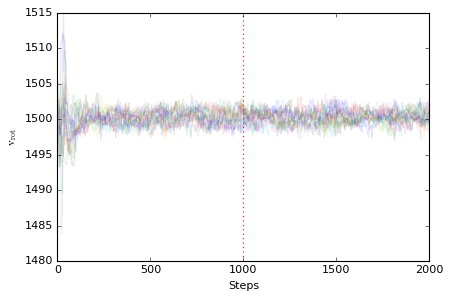

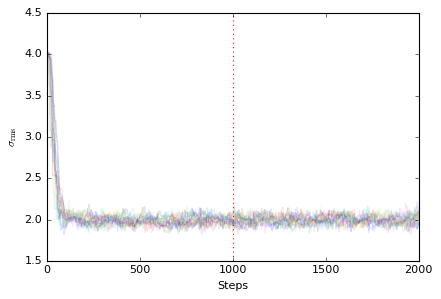

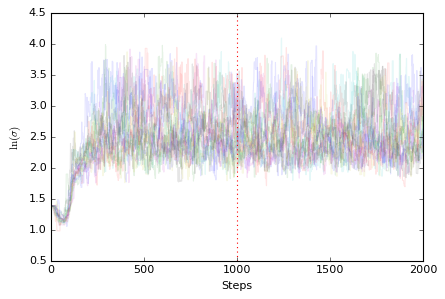

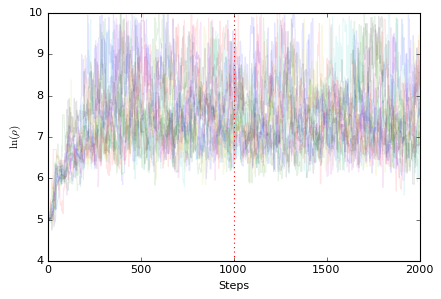

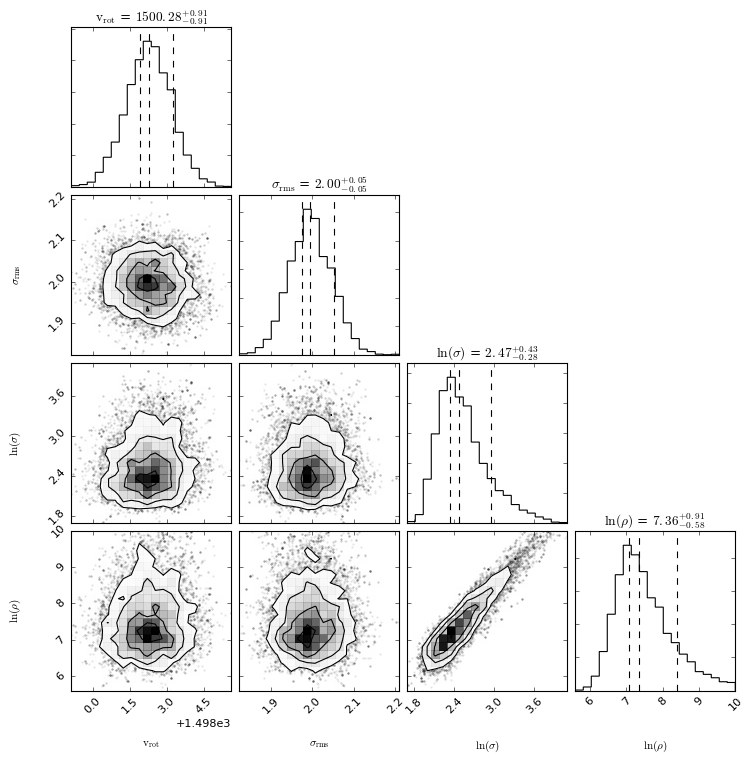

In [44]:
# Diagnosis plots.

import corner

# Plot the samples.

labels = [r'${\rm v_{rot}}$', r'${\rm \sigma_{rms}}$', r'${\rm ln(\sigma)}$', r'${\rm ln(\rho)}$']
for s, sample in enumerate(sampler.chain.T):
    fig, ax = plt.subplots()
    for walker in sample.T:
        ax.plot(walker, alpha=0.1)
    ax.set_xlabel('Steps')
    ax.set_ylabel(labels[s])
    ax.axvline(nburnin, ls=':', color='k')

# Plot the corner plot to show the covariances.

fig = corner.corner(samples, labels=labels, quantiles=[0.34, 0.5, 0.86], show_titles=True)

We find a very good match to the true values for both $v_{\rm rot}$ and the noise in the spectra. We can now consider the case of a non-Gaussian line, such as when it becomes highly optically thick and the core saturates. This is given by $T_{\rm B} = T_{\rm ex} \big(1 - \exp(-\tau)\big)$ where $\tau$ is a Gaussian.

In [67]:
def thick_line(x, x0, dx, Tex, tau):
    """Optically thick line profile."""
    return Tex * (1. - np.exp(-gaussian(x, x0, dx, tau)))

In [70]:
# Build the model spectra with an optical depth of 5.

velax = np.arange(-1980, 2001, 30)

vrot = 1500.
theta = np.linspace(-np.pi, np.pi, 21)[1:]
v_los = vrot * np.cos(theta)

lines = thick_line(velax[None, :], v_los[:, None], 150., 40., 5.0)
lines += 2. * np.random.randn(lines.size).reshape(lines.shape)

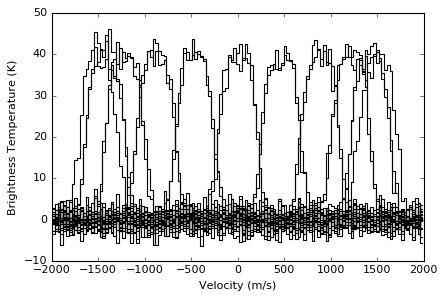

In [71]:
fig, ax = plt.subplots()
for line in lines:
    ax.step(velax, line, where='mid', color='k')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Brightness Temperature (K)')

Clearly these spectra are much broadeer and are not well described by a Gaussian profile. Trying the GP approach to this dataset gives us:

In [72]:
sampler = emcee.EnsembleSampler(nwalkers, 4, ln_probability,
                                args=(lines, theta, velax, vrot))

p0 = np.array([vrot, 4.0, np.log(4.0), np.log(150.)])
dp0 = np.random.randn(nwalkers * len(p0)).reshape(nwalkers, len(p0))
dp0 = np.where(p0 == 0.0, 1.0, p0)[None, :] * (1.0 + 1e-3 * dp0)
p0 = np.where(p0[None, :] == 0.0, dp0 - 1.0, dp0)

sampler.run_mcmc(p0, nburnin + nsteps)
samples = sampler.chain[:, -nsteps:]
samples = samples.reshape(-1, samples.shape[-1])

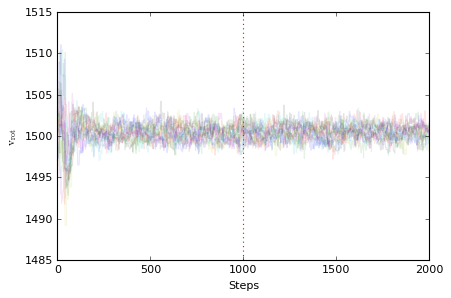

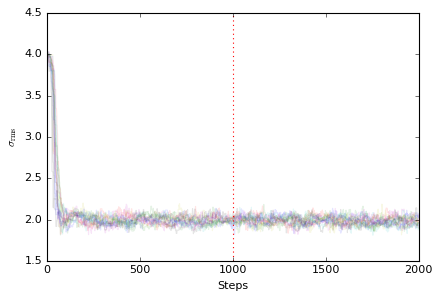

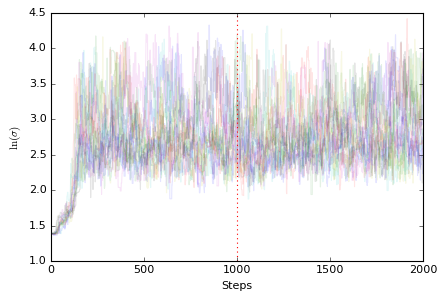

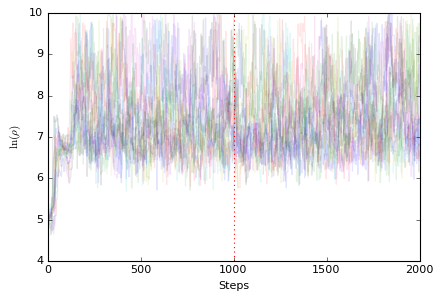

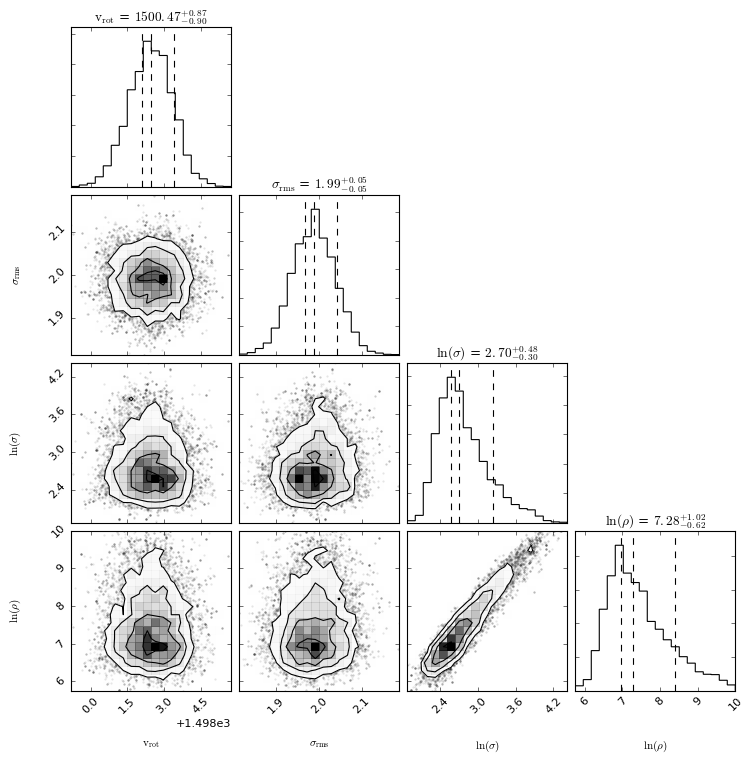

In [73]:
# Samples.

for s, sample in enumerate(sampler.chain.T):
    fig, ax = plt.subplots()
    for walker in sample.T:
        ax.plot(walker, alpha=0.1)
    ax.set_xlabel('Steps')
    ax.set_ylabel(labels[s])
    ax.axvline(nburnin, ls=':', color='r')

# Corner plot.

fig = corner.corner(samples, labels=labels, quantiles=[0.34, 0.5, 0.86], show_titles=True)

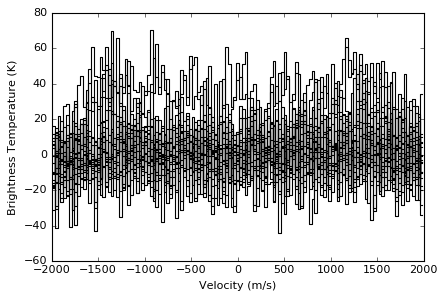

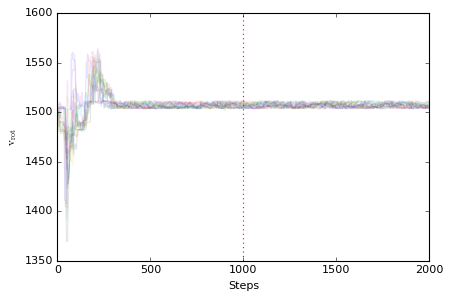

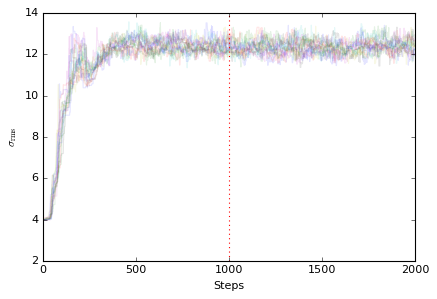

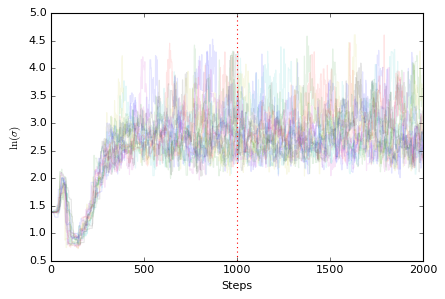

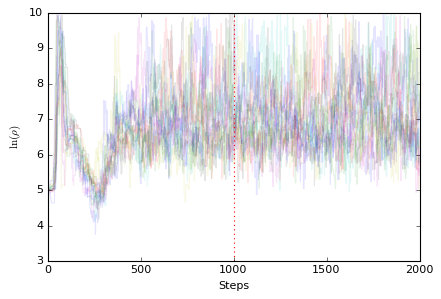

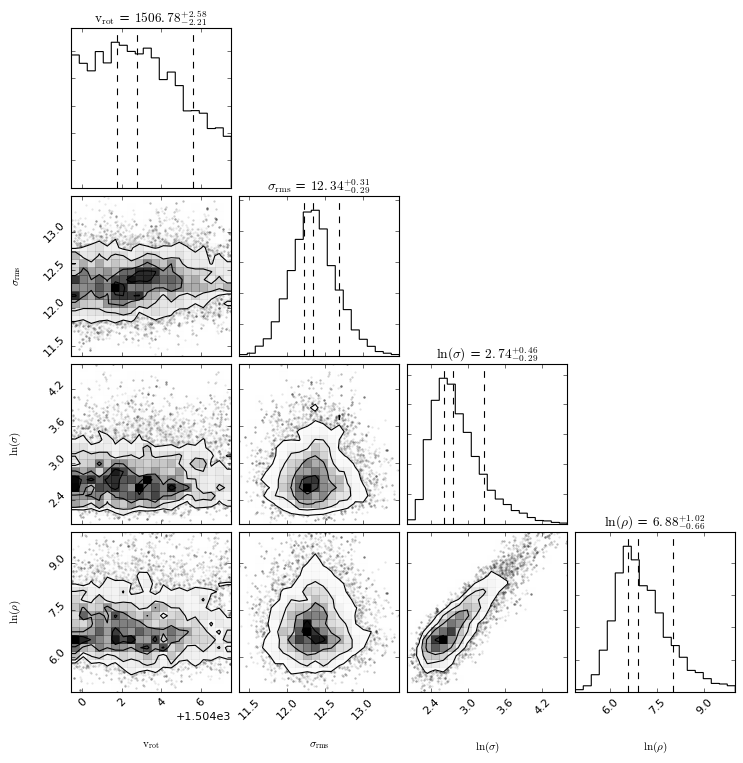

In [81]:
# Build the model spectra with an optical depth of 5 and a SNR of only 3.

velax = np.arange(-1980, 2001, 30)

vrot = 1500.
theta = np.linspace(-np.pi, np.pi, 21)[1:]
v_los = vrot * np.cos(theta)

lines = thick_line(velax[None, :], v_los[:, None], 150., 40., 5.0)
lines += 13. * np.random.randn(lines.size).reshape(lines.shape)

# Plot the lines.

fig, ax = plt.subplots()
for line in lines:
    ax.step(velax, line, where='mid', color='k')
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('Brightness Temperature (K)')

# Run the sampler.

sampler = emcee.EnsembleSampler(nwalkers, 4, ln_probability,
                                args=(lines, theta, velax, vrot))

p0 = np.array([vrot, 4.0, np.log(4.0), np.log(150.)])
dp0 = np.random.randn(nwalkers * len(p0)).reshape(nwalkers, len(p0))
dp0 = np.where(p0 == 0.0, 1.0, p0)[None, :] * (1.0 + 1e-3 * dp0)
p0 = np.where(p0[None, :] == 0.0, dp0 - 1.0, dp0)

sampler.run_mcmc(p0, nburnin + nsteps)
samples = sampler.chain[:, -nsteps:]
samples = samples.reshape(-1, samples.shape[-1])

# Samples.

for s, sample in enumerate(sampler.chain.T):
    fig, ax = plt.subplots()
    for walker in sample.T:
        ax.plot(walker, alpha=0.1)
    ax.set_xlabel('Steps')
    ax.set_ylabel(labels[s])
    ax.axvline(nburnin, ls=':', color='r')

# Corner plot.

fig = corner.corner(samples, labels=labels, quantiles=[0.34, 0.5, 0.86], show_titles=True)